In [1]:
import mediapipe as mp
import csv
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils
points = mpPose.PoseLandmark # Landmarks
path = r"C:/Users/K/Downloads/DATASET/TRAIN/" # enter dataset path
data = []
for p in points:
    x = str(p)[13:]
    data.append(x + "_x")
    data.append(x + "_y")
    data.append(x + "_z")
    data.append(x + "_vis")
data = pd.DataFrame(columns = data)
total = pd.DataFrame()
total2 = pd.DataFrame()

NOSE:
x: 0.7331949472427368
y: 0.5108660459518433
z: -0.4029044806957245
visibility: 0.953056275844574

LEFT_EYE_INNER:
x: 0.7509360909461975
y: 0.5130093097686768
z: -0.369207501411438
visibility: 0.9484298229217529



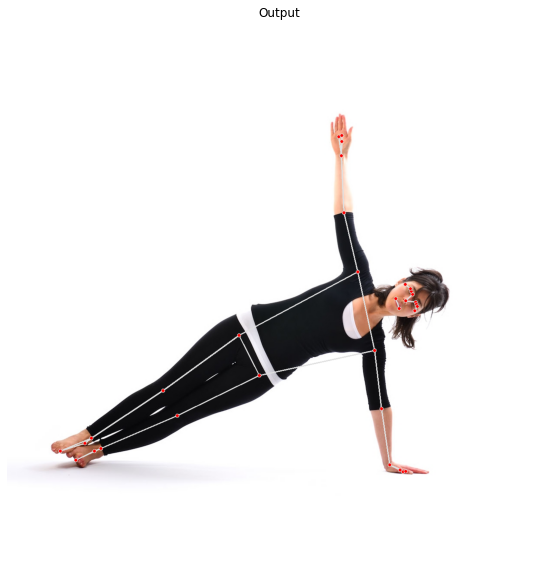

In [28]:
sample_img  = cv2.imread('C:/Users/K/Downloads/DATASET/TRAIN/plank/00000165.jpg')
img_copy = sample_img.copy()
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
if results.pose_landmarks:
    mpDraw.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mpPose.POSE_CONNECTIONS)
    for i in range(2):
        print(f'{mpPose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mpPose.PoseLandmark(i).value]}') 
fig = plt.figure(figsize = [10, 10])
plt.title("Output")
plt.axis('off')
plt.imshow(img_copy[:,:,::-1])
plt.show()

In [7]:
class_names = os.listdir(path)
for class_name in class_names:
    count=0
    temp_data = data.copy()
    for img in os.listdir(path+class_name):
        temp = []
        img = cv2.imread(path + class_name + "/" + img)
        image_height, image_width, _ = img.shape
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = pose.process(imgRGB)
        img_copy = img.copy()
        if results.pose_landmarks:
    #             for i in range(2):
    #                 print(f'{mpPose.PoseLandmark(i).name}:')
    #                 print(f'x: {results.pose_landmarks.landmark[mpPose.PoseLandmark(i).value].x * image_width}')
    #                 print(f'y: {results.pose_landmarks.landmark[mpPose.PoseLandmark(i).value].y * image_height}')
    #                 print(f'z: {results.pose_landmarks.landmark[mpPose.PoseLandmark(i).value].z * image_width}')
    #                 print(f'visibility: {results.pose_landmarks.landmark[mpPose.PoseLandmark(i).value].visibility}\n')
            mpDraw.draw_landmarks(img_copy, results.pose_landmarks, mpPose.POSE_CONNECTIONS) 
            landmarks = results.pose_landmarks.landmark
            for i,j in zip(points,landmarks):
                temp = temp + [j.x, j.y, j.z, j.visibility]
            temp_data.loc[count] = temp
            count +=1


    temp_data['target'] = class_name
    total = pd.concat([total, temp_data])
    # temp_data.to_csv(class_name + "_dataset.csv")

In [14]:
test_path = "C:/Users/K/Downloads/DATASET/TEST/"

for class_name in class_names:
    count=0
    temp_data = data.copy()
    
    for img in os.listdir(test_path+class_name):
        temp = []
        img = cv2.imread(test_path + class_name + "/" + img)
#         image_height, image_width, _ = img.shape
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = pose.process(imgRGB)
    
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
            for j in landmarks:
                temp = temp + [j.x, j.y, j.z, j.visibility]
#             y = model.predict([temp])
            temp_data.loc[count] = temp
            count +=1

    temp_data['target'] = class_name
    total2 = pd.concat([total2, temp_data])

In [23]:
mpDraw.plot_landmarks(results.pose_world_landmarks, mpPose.POSE_CONNECTIONS)

In [6]:
X,y = total.iloc[:,:-1],total['target']

In [7]:
X.shape

(970, 132)

In [18]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, total):
        df = total
        self.x = df.iloc[:, :-1].values
        self.y = df.target.values
        self.y = list(map(self.string_to_vector, self.y))
        self.length = len(df)

    def string_to_vector(self, value):
        data = {"downdog": 0, "goddess": 1, "plank": 2, "tree": 3, "warrior2": 4}
        return data.get(value, None)

    def __getitem__(self, index):
        x = torch.FloatTensor(self.x[index])
        y = torch.LongTensor(self.y)[index]
        return x, y

    def __len__(self):
        return self.length


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(132, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        x = self.layer(x)
        return x



In [19]:

train_dataset = CustomDataset(total)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CustomModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(1000):
    cost = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost / len(train_dataloader)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")


Epoch : 1000, Cost : 1.380


In [27]:
test_dataset = CustomDataset(total2)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=True)

In [31]:
total_size =0
correct = 0
with torch.no_grad():
    model.eval()
    for x, y in test_dataloader:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        
        _, predicted = torch.max(outputs.data, 1)
        total_size += y.size(0)
        correct += (predicted == y).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total_size} %')

Accuracy of the network on the 10000 test images: 53 %


In [16]:
from glob import glob

file_names = glob('*.csv')
total = pd.DataFrame()

for file_name in file_names:
    temp = pd.read_csv(file_name, index_col=0) 
    
    total = pd.concat([total, temp])
total.to_csv("total.csv")

In [22]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [23]:
encoder = LabelEncoder()
encoder.fit(y)
labels = encoder.transform(y)
labels = labels.reshape(-1, 1)
oh_encoder = OneHotEncoder()
oh_encoder.fit(labels)
oh_labels = oh_encoder.transform(labels)

In [32]:
model = SVC(kernel = 'poly')
model.fit(X,y)

SVC(kernel='poly')